# Create a RNN model to text generation
- RNN model at character level
    - Input: n character previous
    - Output: next character
    - Model LSTM
- Use 'El Quijote' to train the generator


In [2]:
# Header
from __future__ import print_function

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

import numpy as np

path = '/home/ubuntu/data/training/keras/'


## Download data and generate sequences

Download quijote from guttenberg project


wget http://www.gutenberg.org/cache/epub/2000/pg2000.txt

In [3]:
#Read book
text = open(path + "pg2000.txt").read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('Chars list: ', chars)
print('total chars:', len(chars))

#Dictionaries to convert char to num & num to char
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


corpus length: 2198927
Chars list:  ['\n', '\r', ' ', '!', '"', '#', '$', '%', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\x81', '\x89', '\x8d', '\x91', '\x93', '\x9a', '\xa0', '\xa1', '\xa9', '\xab', '\xad', '\xaf', '\xb1', '\xb3', '\xb9', '\xba', '\xbb', '\xbc', '\xbf', '\xc2', '\xc3', '\xef']
total chars: 80


In [4]:
# cut the text in semi-redundant sequences of maxlen characters
# One sentence of length 20 for each 3 characters
maxlen = 20
step = 3
sentences = []
next_chars = []
for i in range(300, len(text) - maxlen, step): #Start in line 30 to exclude Gutenberg header.
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))
print(sentences[4996], '-', next_chars[4996])

nb sequences: 732869
e nombre el río taj - o


## Train the model

In [5]:
'''
X: One row by sentence
    in each row a matrix of bool 0/1 of dim length_sentence x num_chars coding the sentence. Dummy variables
y: One row by sentence
    in each row a vector of bool of lengt num_chars with 1 in the next char position
'''

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print('X shape: ',X.shape)
print('y shape: ',y.shape)

Vectorization...
X shape:  (732869, 20, 80)
y shape:  (732869, 80)


In [6]:
# build the model: 2 stacked LSTM
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM


print('Build model 1')
seq_prev_input = Input(shape=(maxlen, len(chars)), name='prev') 
                
# apply forwards LSTM
forwards1 = LSTM(512, dropout_W=0.3, dropout_U=0.3, return_sequences=True)(seq_prev_input)

forwards2 = LSTM(512, dropout_W=0.3, dropout_U=0.3, return_sequences=False)(forwards1)

output = Dense(len(chars), activation='softmax')(forwards2)

model1 = Model(input=seq_prev_input, output=output)
model1.summary()

# try using different optimizers and different optimizer configs
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Build model 1
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
prev (InputLayer)                (None, 20, 80)        0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 20, 512)       1214464     prev[0][0]                       
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 512)           2099200     lstm_1[0][0]                     
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 80)            41040       lstm_2[0][0]                     
Total params: 3354704
_______________________________________________________

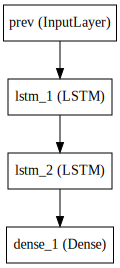

In [ ]:
#Print the model
#Plot the model graph
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model1).create(prog='dot', format='svg'))

In [ ]:
#Fit model
history = model1.fit(X[:600000], y[:600000], batch_size=512, nb_epoch=30,
           validation_data=(X[600000:], y[600000:]))



Train on 600000 samples, validate on 132869 samples
Epoch 1/30
600000/600000 [==============================] - 625s - loss: 2.3064 - acc: 0.3143 - val_loss: 1.9490 - val_acc: 0.4013
Epoch 2/30
600000/600000 [==============================] - 694s - loss: 1.8458 - acc: 0.4247 - val_loss: 1.7759 - val_acc: 0.4594
Epoch 3/30
600000/600000 [==============================] - 694s - loss: 1.5572 - acc: 0.5090 - val_loss: 1.5789 - val_acc: 0.5218
Epoch 6/30
 18432/600000 [..............................] - ETA: 626s - loss: 1.5344 - acc: 0.5137

KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

NameError: name 'history' is not defined

In [ ]:
#Save model
'''
model_name = 'text_generation_model1'

json_string = model1.to_json()
open(path + 'models/mdl_' + model_name + '.json', 'w').write(json_string)
model1.save_weights(path + 'models/w_' + model_name + '.h5')
'''

## Evaluate model

In [11]:
# Load model
from keras.models import model_from_json

model_name = 'text_generation_model1'

model1 = model_from_json(open(path + 'models/mdl_' + model_name + '.json').read())
model1.load_weights(path + 'models/w_' + model_name + '.h5')

In [12]:
maxlen = 20


def sample(a, diversity=1.0):
    '''
    helper function to sample an index from a probability array
    - Diversity control the level of randomless
    '''
    a = np.log(a) / diversity
    a = np.exp(a) / np.sum(np.exp(a), axis=0)
    a /= np.sum(a+0.0000001) #Precission error
    return np.argmax(np.random.multinomial(1, a, 1))


def generate_text(sentence, diversity, current_model, num_char=400):
    sentence_init = sentence
    generated = ''
    for i in range(400):
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.
        preds = current_model.predict(x, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    print()
    print('DIVERSITY: ',diversity)
    print(sentence_init + generated)


In [13]:

sentence = 'mire vuestra merced '
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)



sentence = 'de lo que sucedió a'
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)



sentence = 'de allí a poco come'
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log



DIVERSITY:  0.2
mire vuestra merced que está en la memoria de la mano de la mano de la mano, y a lo menos que en la cabeza de la mano, sino que después de haber de haber de contar la vida de la mano de la mano de mi señora dulcinea del toboso, y el cura que el más deseo que le había de ser el mundo de la cabeza de la cabeza, y aun en la misma mano y de los demás de la mano de los ojos de los caballeros andantes que en la mitad

DIVERSITY:  0.5
mire vuestra merced dicen que se le pareció que un poco se le parecía, que no podía ser cosa de los encubiertos y despedirme del mundo, y que está agravio de los presentes, y de los molineros del toboso, a la señora dulcinea del toboso, sino que no es muy bueno. andando esto,
volviendo a don quijote y sancho en la mano, y de aquélla que allí juntase.

-no es eso -respondió el cura-: ¿por el mesmo se estim

DIVERSITY:  1
mire vuestra merced señor don bernado, y, con otro don quijote sancho, se le había parecía buen segundo, y volveré con alguna p